Imports

In [24]:
# Imports for pyspark
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.session import SparkSession
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import col, unix_timestamp, to_date, datediff, expr
from helper_functions import translate_to_file_string

# Import for seaborn
import seaborn as sbs

# Imports for mathlib
%matplotlib inline
import seaborn as sbs
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



Creating Spark Context

In [25]:
spark = (SparkSession
       .builder
       .appName("HumanResources")
       .getOrCreate())
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

Setting input file

In [26]:
inputFile = translate_to_file_string("./HRDataset.csv")
# load data file.
# create a DataFrame using an ifered Schema
df = spark.read.option("header", "true") \
    .option("inferSchema", "true") \
    .option("delimiter", ",") \
    .csv(inputFile) \
    .withColumnRenamed("_c0", "EmpLastname")\
    .withColumnRenamed("_c1", "EmpFirstname")\
    .withColumnRenamed("_c2", "EmpID")\
    .withColumnRenamed("_c3", "MarriedID")\
    .withColumnRenamed("_c4", "MaritalStatusID")\
    .withColumnRenamed("_c5", "GenderID")\
    .withColumnRenamed("_c6", "EmpStatusID")\
    .withColumnRenamed("_c7", "DeptID")\
    .withColumnRenamed("_c8", "PerfScoreID")\
    .withColumnRenamed("_c9", "FromDiversityJobFairID")\
    .withColumnRenamed("_c10", "Salary")\
    .withColumnRenamed("_c11", "Termd")\
    .withColumnRenamed("_c12", "PositionID")\
    .withColumnRenamed("_c13", "Position")\
    .withColumnRenamed("_c14", "State")\
    .withColumnRenamed("_c15", "Zip")\
    .withColumnRenamed("_c16", "DOB")\
    .withColumnRenamed("_c17", "Sex")\
    .withColumnRenamed("_c18", "MaritalDesc")\
    .withColumnRenamed("_c19", "CitizenDesc")\
    .withColumnRenamed("_c20", "HispanicLatino")\
    .withColumnRenamed("_c21", "RaceDesc")\
    .withColumnRenamed("_c22", "DateofHire")\
    .withColumnRenamed("_c23", "DateofTermination")\
    .withColumnRenamed("_c24", "TermReason")\
    .withColumnRenamed("_c25", "EmploymentStatus")\
    .withColumnRenamed("_c26", "Department")\
    .withColumnRenamed("_c27", "ManagerName")\
    .withColumnRenamed("_c28", "ManagerID")\
    .withColumnRenamed("_c29", "RecruitmentSource")\
    .withColumnRenamed("_c30", "PerformanceScore")\
    .withColumnRenamed("_c31", "EngagementSurvey")\
    .withColumnRenamed("_c32", "EmpSatisfaction")\
    .withColumnRenamed("_c33", "SpecialProjectsCount")\
    .withColumnRenamed("_c34", "LastPerformanceReview_Date")\
    .withColumnRenamed("_c35", "DaysLateLast30")\
    .withColumnRenamed("_c36", "Absences")

print(df.printSchema())



root
 |-- EmpLastname: string (nullable = true)
 |-- EmpFirstname: string (nullable = true)
 |-- EmpID: integer (nullable = true)
 |-- MarriedID: integer (nullable = true)
 |-- MaritalStatusID: integer (nullable = true)
 |-- GenderID: integer (nullable = true)
 |-- EmpStatusID: integer (nullable = true)
 |-- DeptID: integer (nullable = true)
 |-- PerfScoreID: integer (nullable = true)
 |-- FromDiversityJobFairID: integer (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Termd: integer (nullable = true)
 |-- PositionID: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: integer (nullable = true)
 |-- DOB: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- MaritalDesc: string (nullable = true)
 |-- CitizenDesc: string (nullable = true)
 |-- HispanicLatino: string (nullable = true)
 |-- RaceDesc: string (nullable = true)
 |-- DateofHire: string (nullable = true)
 |-- DateofTermination: string (nullable

This is an initial analysis of the HR dataset:
Creation of a barplot consisting of 2 axes: (x) recruitment score with a "hue"/variation of different performance scores categories (y) percentage. The goal of this graph is the visualization in how good a employee performs in relation to from which source he has been recruited.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Website'),
  Text(1, 0, 'CareerBuilder'),
  Text(2, 0, 'Diversity Job Fair'),
  Text(3, 0, 'LinkedIn'),
  Text(4, 0, 'Employee Referral'),
  Text(5, 0, 'Indeed'),
  Text(6, 0, 'Google Search'),
  Text(7, 0, 'Other'),
  Text(8, 0, 'On-line Web application')])

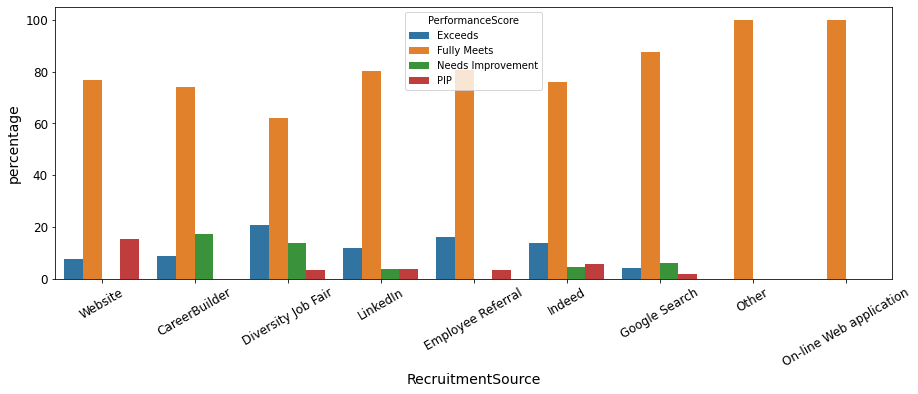

In [27]:
plt.figure(figsize=(15,5))
dfPandas= df.toPandas()
perfscore_percentage = (dfPandas.groupby(['RecruitmentSource'])['PerformanceScore']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('PerformanceScore'))
sbs.barplot(x="RecruitmentSource", y="percentage", hue="PerformanceScore", data=perfscore_percentage)
plt.xticks(rotation = 30)

Preprocessing

In [28]:
# Fill null values
print(df.printSchema())
df = df.na.fill( {'TermReason': 'Unknown', 'ManagerID': 0, 'DaysLateLast30': 0, 'DateofTermination': '1/01/2021', 'LastPerformanceReview_Date': '1/01/2021'} )
print(df.printSchema())
# Converte date-strings to dates
df = df.withColumn('DateofHire', to_date(unix_timestamp(col('DateofHire'), 'M/dd/yyyy').cast("timestamp")))
df = df.withColumn('DOB', to_date(unix_timestamp(col('DOB'), 'MM/dd/yy').cast("timestamp")))
df = df.withColumn('DateofTermination', to_date(unix_timestamp(col('DateofTermination'), 'M/dd/yyyy').cast("timestamp")))
df = df.withColumn('LastPerformanceReview_Date', to_date(unix_timestamp(col('LastPerformanceReview_Date'), 'M/dd/yyyy').cast("timestamp")))
# Add new column for days worked in company
df = df.withColumn("DaysWorked", datediff(col("DateofTermination"), col("DateofHire")))

# Manmeet cleaning sex and payrate

# Print new Schema
print(df.printSchema())

root
 |-- EmpLastname: string (nullable = true)
 |-- EmpFirstname: string (nullable = true)
 |-- EmpID: integer (nullable = true)
 |-- MarriedID: integer (nullable = true)
 |-- MaritalStatusID: integer (nullable = true)
 |-- GenderID: integer (nullable = true)
 |-- EmpStatusID: integer (nullable = true)
 |-- DeptID: integer (nullable = true)
 |-- PerfScoreID: integer (nullable = true)
 |-- FromDiversityJobFairID: integer (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Termd: integer (nullable = true)
 |-- PositionID: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: integer (nullable = true)
 |-- DOB: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- MaritalDesc: string (nullable = true)
 |-- CitizenDesc: string (nullable = true)
 |-- HispanicLatino: string (nullable = true)
 |-- RaceDesc: string (nullable = true)
 |-- DateofHire: string (nullable = true)
 |-- DateofTermination: string (nullable

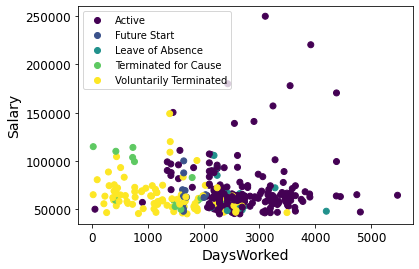

In [29]:
dfPandas = df.toPandas()
scatter = plt.scatter(dfPandas["DaysWorked"], dfPandas["Salary"],c=dfPandas['EmpStatusID'])
plt.xlabel("DaysWorked")
plt.ylabel("Salary")
plt.legend(handles=scatter.legend_elements()[0],labels=['Active','Future Start','Leave of Absence','Terminated for Cause','Voluntarily Terminated'])
plt.show()

Rouven: Scatter plot 

In [30]:
empLastnameIndexer = StringIndexer().setInputCol("EmpLastname").setOutputCol("EmpLastname-num").fit(df)
empFirstnameIndexer = StringIndexer().setInputCol("EmpFirstname").setOutputCol("EmpFirstname-num").fit(df)
positionIndexer = StringIndexer().setInputCol("Position").setOutputCol("Position-num").fit(df)
stateIdIndexer = StringIndexer().setInputCol("State").setOutputCol("State-num").fit(df)
sexIndexer = StringIndexer().setInputCol("Sex").setOutputCol("Sex-num").fit(df)
maritalDescIndexer = StringIndexer().setInputCol("MaritalDesc").setOutputCol("MaritalDesc-num").fit(df)
citizenDescIndexer = StringIndexer().setInputCol("CitizenDesc").setOutputCol("CitizenDesc-num").fit(df)
hispanicLatinoIndexer = StringIndexer().setInputCol("HispanicLatino").setOutputCol("HispanicLatino-num").fit(df)
raceDescIndexer = StringIndexer().setInputCol("RaceDesc").setOutputCol("RaceDesc-num").fit(df)
termReasonIndexer = StringIndexer().setInputCol("TermReason").setOutputCol("TermReason-num").fit(df)
empStatusIndexer = StringIndexer().setInputCol("EmploymentStatus").setOutputCol("EmploymentStatus-num").fit(df)
departmentIndexer = StringIndexer().setInputCol("Department").setOutputCol("Department-num").fit(df)
managerNameIndexer = StringIndexer().setInputCol("ManagerName").setOutputCol("ManagerName-num").fit(df)
recruitSourceIndexer = StringIndexer().setInputCol("RecruitmentSource").setOutputCol("RecruitmentSource-num").fit(df)
performanceScoreIndexer = StringIndexer().setInputCol("PerformanceScore").setOutputCol("PerformanceScore-num").fit(df)

In [31]:
print(df.show())
featureCols = df.columns.copy()
featureCols.remove("EmpLastname")
featureCols.remove("EmpFirstname")
featureCols.remove("Position")
featureCols.remove("State")
featureCols.remove("Sex")
featureCols.remove("MaritalDesc")
featureCols.remove("HispanicLatino")
featureCols.remove("RaceDesc")
featureCols.remove("TermReason")
featureCols.remove("EmploymentStatus")
featureCols.remove("Department")
featureCols.remove("ManagerName")
featureCols.remove("RecruitmentSource")
featureCols.remove("PerformanceScore")
featureCols = featureCols +["EmpLastname-num", "EmpFirstname-num","Position-num","State-num","Sex-num", "MaritalDesc-num", "HispanicLatino-num", "RaceDesc-num", "TermReason-num", "EmploymentStatus-num", "Department-num", "ManagerName-num", "RecruitmentSource-num", "PerformanceScore-num"]

+-----------+------------+-----+---------+---------------+--------+-----------+------+-----------+----------------------+------+-----+----------+--------------------+-----+-----+----------+---+-----------+-------------------+--------------+--------------------+----------+-----------------+-----------------+--------------------+--------------------+---------------+---------+--------------------+----------------+----------------+---------------+--------------------+--------------------------+--------------+--------+----------+
|EmpLastname|EmpFirstname|EmpID|MarriedID|MaritalStatusID|GenderID|EmpStatusID|DeptID|PerfScoreID|FromDiversityJobFairID|Salary|Termd|PositionID|            Position|State|  Zip|       DOB|Sex|MaritalDesc|        CitizenDesc|HispanicLatino|            RaceDesc|DateofHire|DateofTermination|       TermReason|    EmploymentStatus|          Department|    ManagerName|ManagerID|   RecruitmentSource|PerformanceScore|EngagementSurvey|EmpSatisfaction|SpecialProjectsCount|L

In [32]:
assembler =  VectorAssembler(outputCol="features", inputCols=list(featureCols))

labeledData = empLastnameIndexer.transform(df)
print(labeledData.printSchema())

root
 |-- EmpLastname: string (nullable = true)
 |-- EmpFirstname: string (nullable = true)
 |-- EmpID: integer (nullable = true)
 |-- MarriedID: integer (nullable = true)
 |-- MaritalStatusID: integer (nullable = true)
 |-- GenderID: integer (nullable = true)
 |-- EmpStatusID: integer (nullable = true)
 |-- DeptID: integer (nullable = true)
 |-- PerfScoreID: integer (nullable = true)
 |-- FromDiversityJobFairID: integer (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Termd: integer (nullable = true)
 |-- PositionID: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: integer (nullable = true)
 |-- DOB: date (nullable = true)
 |-- Sex: string (nullable = true)
 |-- MaritalDesc: string (nullable = true)
 |-- CitizenDesc: string (nullable = true)
 |-- HispanicLatino: string (nullable = true)
 |-- RaceDesc: string (nullable = true)
 |-- DateofHire: date (nullable = true)
 |-- DateofTermination: date (nullable = tru

In [33]:
labeledData = empLastnameIndexer.transform(df)
# pipeline all indexers
indexedLabeledData = positionIndexer.transform(stateIdIndexer.transform(sexIndexer.transform(maritalDescIndexer.transform(citizenDescIndexer.transform(hispanicLatinoIndexer.transform(raceDescIndexer.transform(termReasonIndexer.transform(empStatusIndexer.transform(departmentIndexer.transform(managerNameIndexer.transform(recruitSourceIndexer.transform(performanceScoreIndexer.transform(empFirstnameIndexer.transform(labeledData))))))))))))))
print(indexedLabeledData)
labeledPointData = assembler.transform(indexedLabeledData)
labeledPointData.show()

DataFrame[EmpLastname: string, EmpFirstname: string, EmpID: int, MarriedID: int, MaritalStatusID: int, GenderID: int, EmpStatusID: int, DeptID: int, PerfScoreID: int, FromDiversityJobFairID: int, Salary: int, Termd: int, PositionID: int, Position: string, State: string, Zip: int, DOB: date, Sex: string, MaritalDesc: string, CitizenDesc: string, HispanicLatino: string, RaceDesc: string, DateofHire: date, DateofTermination: date, TermReason: string, EmploymentStatus: string, Department: string, ManagerName: string, ManagerID: int, RecruitmentSource: string, PerformanceScore: string, EngagementSurvey: double, EmpSatisfaction: int, SpecialProjectsCount: int, LastPerformanceReview_Date: date, DaysLateLast30: int, Absences: int, DaysWorked: int, EmpLastname-num: double, EmpFirstname-num: double, PerformanceScore-num: double, RecruitmentSource-num: double, ManagerName-num: double, Department-num: double, EmploymentStatus-num: double, TermReason-num: double, RaceDesc-num: double, HispanicLatin

IllegalArgumentException: Data type date of column DOB is not supported.
Data type string of column CitizenDesc is not supported.
Data type date of column DateofHire is not supported.
Data type date of column DateofTermination is not supported.
Data type date of column LastPerformanceReview_Date is not supported.